In [1]:
# GNU LESSER GENERAL PUBLIC LICENSE
# Version 3, 29 June 2007.
# Copyright (C) 2007 Free Software Foundation, Inc. <http://fsf.org/>.
# Everyone is permitted to copy and distribute verbatim copies of this 
# license document, but changing it is not allowed.

# Creating Voronoi Tesselations
## Automated Simulation in GIS
---

### James Gaboardi, 2016

In [18]:
import numpy as np
import pysal as ps
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import shapely
import time
from scipy.spatial import Voronoi, voronoi_plot_2d
%matplotlib inline

mpl.rcParams['figure.figsize'] = 20,20  #set the default map size
mpl.rcParams['patch.linewidth'] = 0.5  #set default polygon line width

np.random.seed(352)

# Local path on user's machine
path = '/Users/jgaboardi/Algorithms_etc./Data/'

In [3]:
t1_shp_reads = time.time()

# Waverly Hills streets and bounding box
streets = gpd.read_file(path+'Waverly_Trim/Waverly.shp')
streets.to_crs(epsg=2779, inplace=True) # NAD83(HARN) / Florida North
streets.to_file(path+'waverly/waverly.shp')
shp_waverly = ps.open(path+'waverly/waverly.shp')
b_box = shp_waverly.bbox

'''
# Leon County streets and bounding box
streets = gpd.read_file(path+'Leon_County/LCSTSEG.shp')
streets.to_crs(epsg=2779, inplace=True) # NAD83(HARN) / Florida North
streets.to_file(path+'leon/leon.shp')
shp_Leon = ps.open(path+'leon/leon.shp')
b_box = shp_Leon.bbox
'''
t2_shp_reads = time.time()-t1_shp_reads
print t2_shp_reads

0.427912950516


In [4]:
# Individual street buffers in meters
intial_buffer = streets.buffer(50)  
intial_buffer[:5]

0    POLYGON ((623124.0407875385 164212.5102460865,...
1    POLYGON ((622546.5762248621 163255.235891574, ...
2    POLYGON ((623559.7869314271 165528.3883790929,...
3    POLYGON ((623200.6855916528 164368.5069398382,...
4    POLYGON ((623558.3641320666 165459.8080567809,...
dtype: object

In [5]:
# Union of individual buffers
union_buffer = intial_buffer.unary_union  
union_buffer = gpd.GeoSeries(union_buffer)
union_buffer.crs = streets.crs
union_buffer = gpd.GeoDataFrame(union_buffer, crs=streets.crs)
union_buffer.columns = ['geometry']

In [6]:
# Create convex hull buffer union
convex_hull_of_union = gpd.GeoDataFrame(union_buffer.convex_hull)
convex_hull_of_union.columns = ['geometry']

In [7]:
# Generate (n) simulated households
n = 20000
t1_allpoints = time.time()
np.random.seed(352)
x = np.random.uniform(b_box[0], b_box[2], n)
np.random.seed(850)
y = np.random.uniform(b_box[1], b_box[3], n)  
simulated_coords = zip(x,y)
simulated_coord_points = [shapely.geometry.Point(xy_coord) for xy_coord in simulated_coords]
simulated_households = gpd.GeoDataFrame(simulated_coord_points, crs=streets.crs)
simulated_households.columns = ['geometry']
t2_allpoints = time.time()-t1_allpoints
print t2_allpoints, 'seconds to simulate households in Waverly'

0.295053958893 seconds to simulate households in Waverly


In [8]:
# Identify households within the buffer
t1_intersection = time.time()
intersection = [union_buffer['geometry'].intersection(hh) for hh in simulated_households['geometry']]
t2_intersection = time.time()-t1_intersection
print t2_intersection, 'seconds to identify households within the 50m street buffer'
intersection = gpd.GeoDataFrame(intersection, crs=streets.crs)
intersection.columns = ['geometry']

# Ignore households not in the buffer --> shapely.geometry.collection.GeometryCollection
households_gdf = intersection[intersection.geom_type != 'GeometryCollection']
households_gdf[:5]

155.523869038 seconds to identify households within the 50m street buffer


,geometry
2,POINT (621913.3153830337 164903.3379650218)
3,POINT (621612.0857702466 164217.1288344094)
5,POINT (621854.4787915241 163374.7302612905)
7,POINT (622860.0605300277 163653.4038665046)
8,POINT (621477.7574525437 164085.8951444005)


In [9]:
# Create list of household coordinates to feed into Voronoi calculator
household_coords = []
for ids,coords in households_gdf['geometry'].iteritems():
    household_coords.append([coords.x, coords.y])

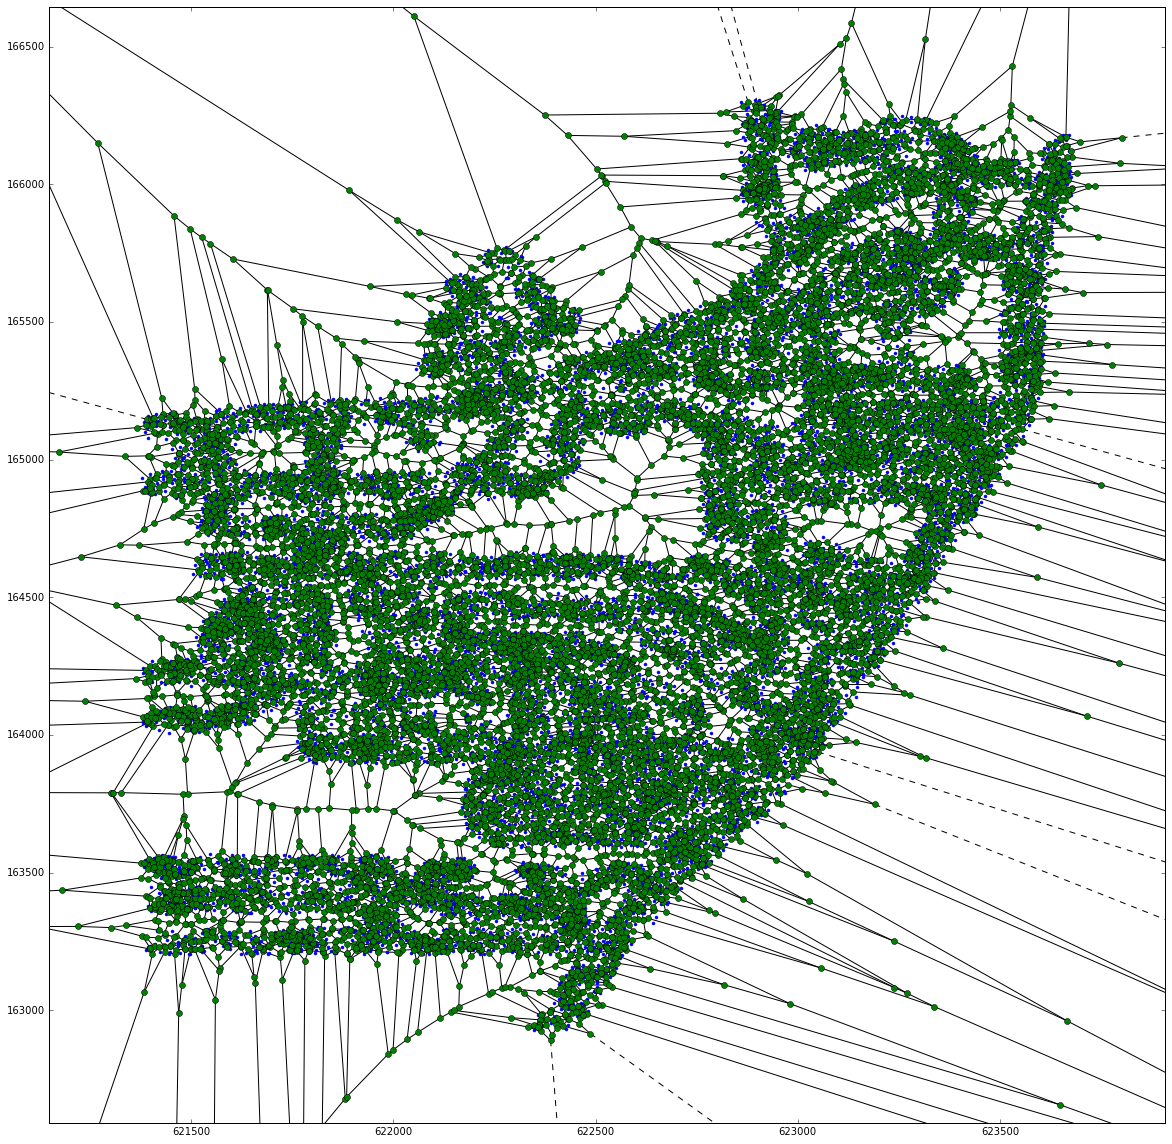

1.69060492516 seconds to instantiate the Voronoi Tessellation and plot the diagram
8356 points
8357 regions


In [10]:
# Instantiate and Plot the Voronoi    
t1_voronoi = time.time()
vor = Voronoi(household_coords)
voronoi_plot_2d(vor)
plt.show()
t2_voronoi = time.time()-t1_voronoi
print t2_voronoi, 'seconds to instantiate the Voronoi Tessellation and plot the diagram'
print vor.npoints, 'points'
print len(vor.regions), 'regions'

In [11]:
# Create geometries from the vertices and ridges of the Voronoi

'''
# Option 1: ignore all lines that go to infinity (-1)
polylines = [shapely.geometry.LineString(vor.vertices[line])
         for line in vor.ridge_vertices
         if -1 not in line]

# Option 2: use all lines
polylines = [shapely.geometry.LineString(vor.vertices[line])
         for line in vor.ridge_vertices]
'''
# Option 3: remove -1 from ridges to make all voronoi polygons finite
vor_polys = []
for region in vor.regions:
    if region:
        if -1 in region:
            region = region[:] # so we don't change the original voronoi output
            region.remove(-1)  # there can only be one -1 in the index list
        vor_polys.append(shapely.geometry.MultiPoint(vor.vertices[region]).convex_hull)

In [12]:
# Create a dataframe of the complete set of Voronoi polygons
voronoi_all_df = gpd.GeoDataFrame(vor_polys, columns=['geometry'], crs=streets.crs)

In [13]:
# Create a dataframe of the complete set of Voronoi polygon centroids
voronoi_all_centroids = gpd.GeoDataFrame(voronoi_all_df.centroid, columns=['geometry'], crs=streets.crs)

In [14]:
# Create a dataframe of the set of Voronoi polygons within the convex hull of the street buffer union
poly_in_hull = [convex_hull_of_union['geometry'].intersection(hh_vor) for hh_vor in voronoi_all_df['geometry']]
voronoi_in_df = gpd.GeoDataFrame(poly_in_hull, crs=streets.crs)
voronoi_in_df.columns = ['geometry']

In [15]:
# Create a dataframe of the set of Voronoi polygon centroids within the bounding box
voronoi_in_centroids = gpd.GeoDataFrame(voronoi_in_df.centroid, crs=streets.crs)
voronoi_in_centroids.columns = ['geometry']

In [16]:
# Write out all dataframes to .shp
households_gdf.to_file(path+'households/households.shp')
convex_hull_of_union.to_file(path+'convex_hull/hull.shp')
voronoi_all_centroids.to_file(path+'voronoi/centroids_all.shp')
voronoi_all_df.to_file(path+'voronoi/voronoi_all.shp')
voronoi_in_centroids.to_file(path+'voronoi/centroids_in.shp')
voronoi_in_df.to_file(path+'voronoi/voronoi_in.shp')

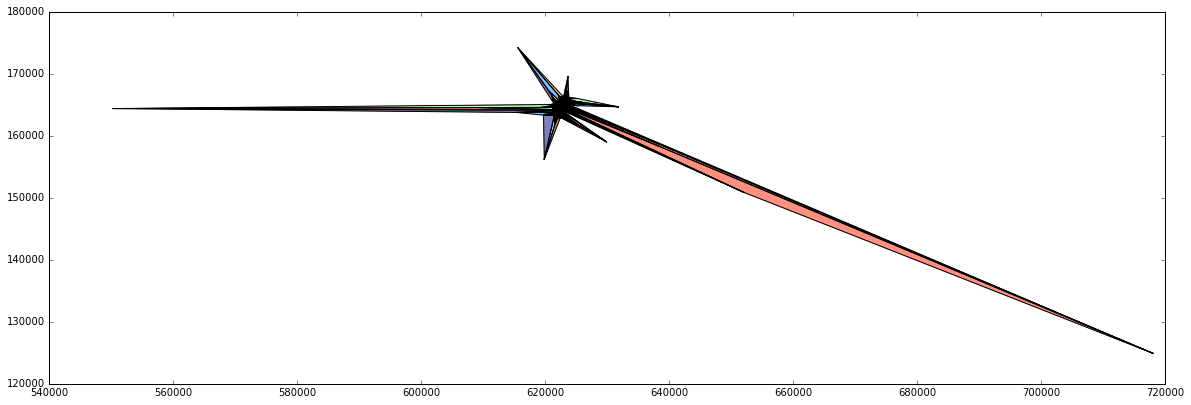

In [19]:
# All finite voronoi polygons
voronoi_all_df.plot()

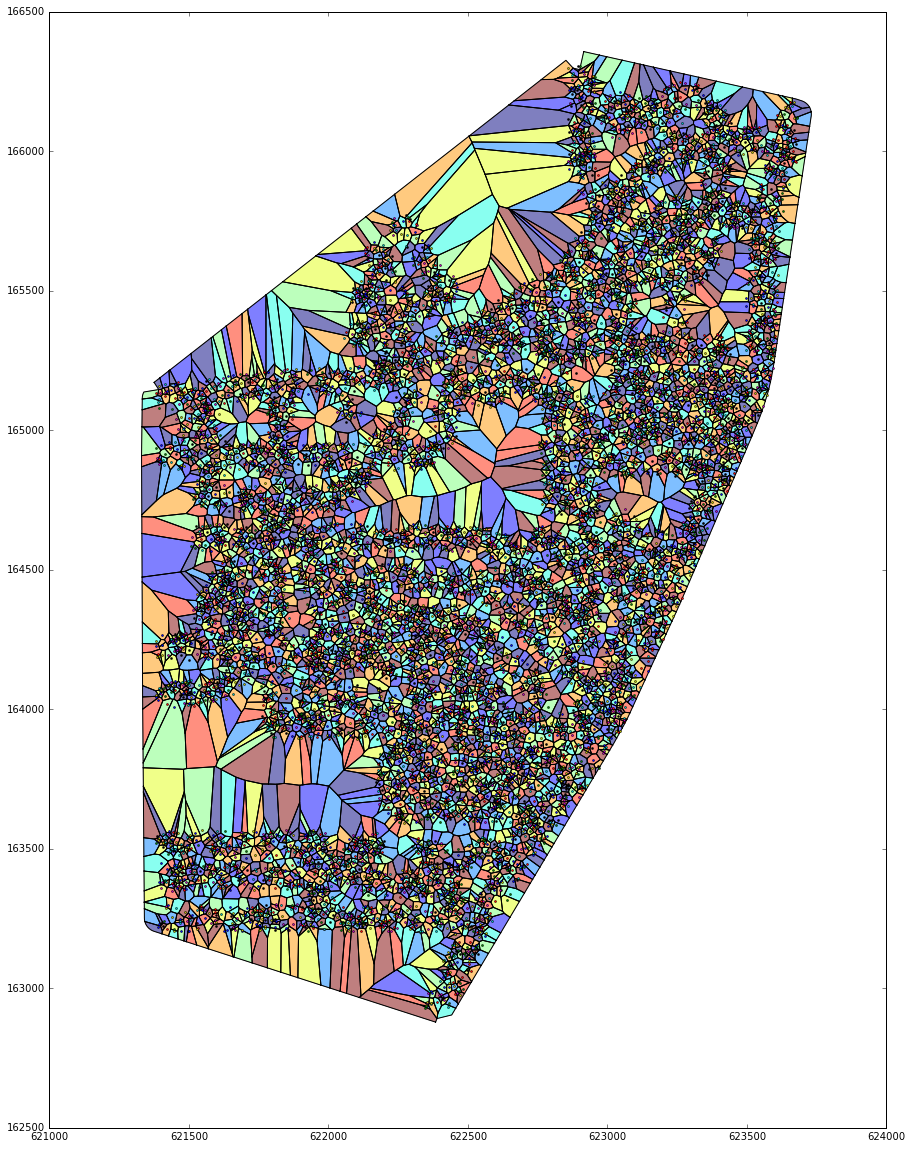

In [17]:
# All households and all finite voronoi polygons trimmed down to a convex hull of the union buffer
voronoi_in_df.plot()
households_gdf.plot()

------------